# Train AE with data generated on MullerBrown potential 

In [1]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from potentials.MullerBrown import MullerBrown
from simulations.UnbiasedMD import OverdampedLangevin

Generate dataset 

In [4]:
pot = MullerBrown()

In [5]:
beta = 0.05
dt = 0.0001
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 10**5

In [6]:
traj_dict1 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [7]:
x_0 = pot.minR
traj_dict2 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

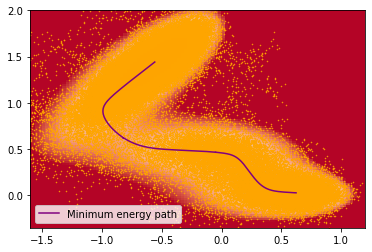

In [8]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax.scatter(traj_dict1["x_traj"][:, 0], traj_dict1["x_traj"][:, 1], marker=".", color="orange", s=1)
ax.scatter(traj_dict2["x_traj"][:, 0], traj_dict2["x_traj"][:, 1], marker=".", color="orange", s=1)
ax.legend()

In [9]:
dataset = {"boltz_points": np.append(traj_dict1["x_traj"], traj_dict2["x_traj"], axis=0)}

In [10]:
dataset.keys()

dict_keys(['boltz_points'])

Import AE model 

In [11]:
from autoencoders.ae_models import DeepAutoEncoder
from autoencoders.train_aes import TainAEOneDecoder

Create autoencoder object

In [12]:
ae = DeepAutoEncoder([2, 5, 1], [1, 10, 10, 2], 0)

Created training object

In [13]:
ae_training = TainAEOneDecoder(ae, pot, dataset)

Set the training size and do the train-test split

In [14]:
ae_training.train_test_split(train_size=2 * 10**3)
ae_training.split_training_dataset_K_folds(2)
ae_training.set_train_val_data(0)

Set the optimizer 

In [15]:
ae_training.set_optimizer('Adam', 0.005)

Set the loss function parameters 

In [16]:
loss_params = {}
loss_params["mse_boltz_weight"] = 1.0
loss_params["squared_grad_boltz_weight"] = 0. * 10**(-3)
loss_params["n_wait"] = 50
ae_training.set_loss_weight(loss_params)

mse_react_weight value not provided, set to default value of:  0.0
l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
pen_points_weight value not provided, set to default value of:  0.0
var_dist_dec_weight value not provided, set to default value of:  0
n_bins_var_dist_dec value not provided, set to default value of:  20


Set the max number of epoch and batch size 

In [17]:
batch_size = 100
max_epochs = 1000

Train 

In [18]:
loss_dict = ae_training.train(batch_size, max_epochs)

training ends after 743 epochs.



Plot the evolution of the loss stating from the 100th epoch 

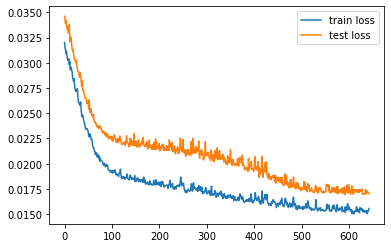

In [19]:
plt.figure()
plt.plot(loss_dict["train_loss"][100:], label='train loss')
plt.plot(loss_dict["test_loss"][100:], label='test loss')
plt.legend()

Plot the conditionnal averages on the potential heat map 

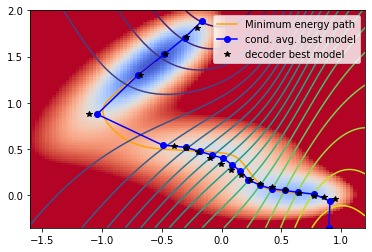

In [20]:
fig = plt.figure()
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ae_training.plot_encoder_iso_levels(ax, 20)
ae_training.plot_conditional_averages(ax, 20)
ax.legend()

Plot convergence of the principal curve 

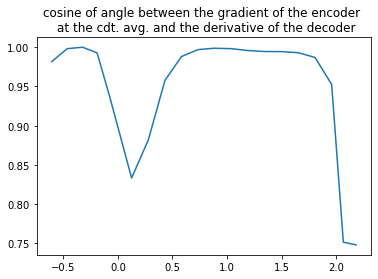

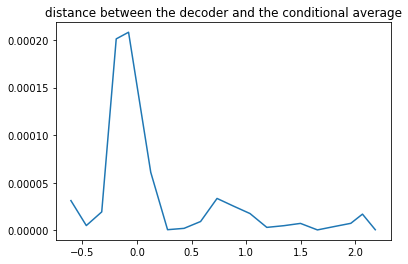

In [21]:
ae_training.plot_principal_curve_convergence(20)